# Faiq Azmi Nurfaizi           (201810370311047)
# Muhammad Reza Fahlopy Dharma (201810370311059)

# Model 1

In [ ]:
from google.colab import files 
from pathlib import Path
import os
import pandas as pd
import json
import zipfile
import matplotlib.pyplot as plt

In [ ]:
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}'}

In [21]:
api_token = {"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}
with open('kaggle.json', 'w') as file: 
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [22]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

In [23]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

a-large-scale-fish-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [24]:
from zipfile import ZipFile 
file_name = "a-large-scale-fish-dataset.zip" #

with ZipFile(file_name,'r') as zip : 
  zip.extractall() 
  print('Berhasil') 

Berhasil


In [ ]:
dataset_path = Path(r'/content/Fish_Dataset')

file_path = list(dataset_path.glob(r'**/*.png'))


labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [ ]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

,image,label
0,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
1,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
2,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
3,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
4,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat


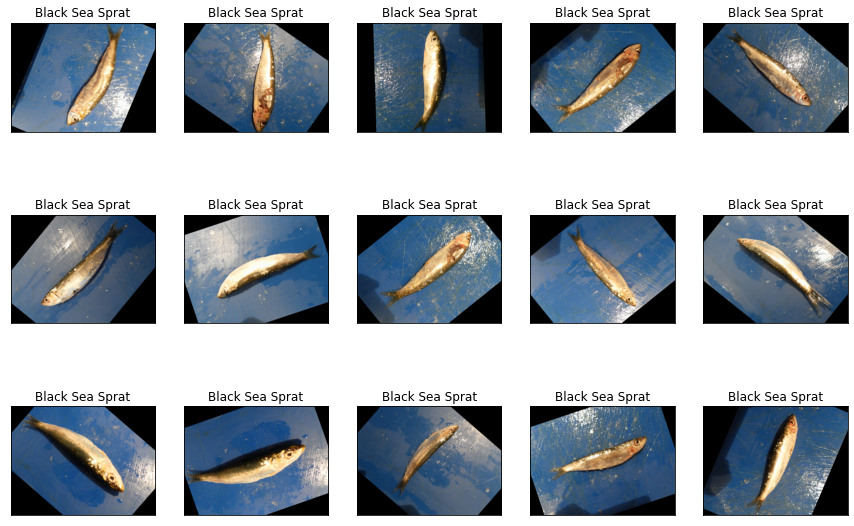

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [ ]:
df.label.value_counts()

Black Sea Sprat          1000
Hourse Mackerel          1000
Trout GT                 1000
Hourse Mackerel GT       1000
Shrimp                   1000
Sea Bass                 1000
Black Sea Sprat GT       1000
Gilt-Head Bream GT       1000
Shrimp GT                1000
Striped Red Mullet GT    1000
Red Sea Bream            1000
Trout                    1000
Red Sea Bream GT         1000
Sea Bass GT              1000
Gilt-Head Bream          1000
Red Mullet               1000
Striped Red Mullet       1000
Red Mullet GT            1000
Name: label, dtype: int64

In [ ]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Red Sea Bream         1000
Black Sea Sprat       1000
Hourse Mackerel       1000
Sea Bass              1000
Striped Red Mullet    1000
Shrimp                1000
Red Mullet            1000
Gilt-Head Bream       1000
Trout                 1000
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD, Nadam

In [ ]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [ ]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5040, 2)
Shape of test data (2700, 2)
Shape of validation data (1260, 2)


In [ ]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 5040 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.


In [ ]:
input_shape = (200, 200, 3)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, validation_data=val, epochs=100)

Epoch 1/100
 97/158 [=================>............] - ETA: 38s - loss: 2.1955 - accuracy: 0.1188

In [ ]:
model.save('model1-fish1.h5')

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [ ]:
pred = model.predict(test)

In [ ]:
import numpy as np
pred = np.argmax(pred, axis=1)

In [ ]:
labels = train.class_indices
labels

In [ ]:
labels = dict((v,k) for k, v in labels.items())
labels

In [ ]:
y_pred = [labels[k] for k in pred]
print(classification_report(x_test.label, y_pred))

In [ ]:
print(confusion_matrix(x_test.label, y_pred))

In [ ]:
test_accuracy = model.evaluate(test)[1]

# Model 2

In [ ]:
files.upload()

In [ ]:
api_token = {"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}
with open('kaggle.json', 'w') as file: 
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

In [ ]:
from zipfile import ZipFile 
file_name = "a-large-scale-fish-dataset.zip" #

with ZipFile(file_name,'r') as zip : 
  zip.extractall() 
  print('Berhasil') 

In [ ]:
dataset_path = Path(r'/content/Fish_Dataset')

file_path = list(dataset_path.glob(r'**/*.png'))


labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [ ]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [ ]:
df.label.value_counts()

In [ ]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

In [ ]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [ ]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

In [ ]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

In [ ]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model2.summary()

In [ ]:
model2.compile(optimizer="SGD", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model2.fit(train, validation_data=val, epochs=5, callbacks=callback)

In [ ]:
model2.save('model2-fish1.h5')

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [ ]:
pred = model2.predict(test)

In [ ]:
import numpy as np
pred = np.argmax(pred, axis=1)

In [ ]:
labels = train.class_indices
labels

In [ ]:
labels = dict((v,k) for k, v in labels.items())
labels

In [ ]:
y_pred = [labels[k] for k in pred]
print(classification_report(x_test.label, y_pred))

In [ ]:
print(confusion_matrix(x_test.label, y_pred))

In [ ]:
test_accuracy = model2.evaluate(test)[1]

# Model 3

In [ ]:
files.upload()

In [ ]:
api_token = {"username":"rezafdz","key":"fd16295d7b817e274541292110c8f784"}
with open('kaggle.json', 'w') as file: 
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

In [ ]:
from zipfile import ZipFile 
file_name = "a-large-scale-fish-dataset.zip" #

with ZipFile(file_name,'r') as zip : 
  zip.extractall() 
  print('Berhasil') 

In [ ]:
dataset_path = Path(r'/content/Fish_Dataset')

file_path = list(dataset_path.glob(r'**/*.png'))


labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [ ]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [ ]:
df.label.value_counts()

In [ ]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

In [ ]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [ ]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

In [ ]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

In [ ]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model3.summary()

In [ ]:
model3.compile(optimizer="Nadam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model3.fit(train, validation_data=val, epochs=5, callbacks=callback)

In [ ]:
model3.save('model3-fish1.h5')

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [ ]:
pred = model3.predict(test)

In [ ]:
import numpy as np
pred = np.argmax(pred, axis=1)

In [ ]:
labels = train.class_indices
labels

In [ ]:
labels = dict((v,k) for k, v in labels.items())
labels

In [ ]:
y_pred = [labels[k] for k in pred]
print(classification_report(x_test.label, y_pred))

In [ ]:
print(confusion_matrix(x_test.label, y_pred))

In [ ]:
test_accuracy = model3.evaluate(test)[1]